In [1]:
from datetime import datetime
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
yf.pdr_override()

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:

def get_stock_price(ticker, start_date, end_date):
    prices = web.get_data_yahoo(ticker,start_date,end_date)
    # prices = prices["Adj Close"].dropna(how="all") 
    return prices


tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
end = datetime.now()
start = datetime(end.year-2, end.month, end.day)
portfolio = get_stock_price(tech_list, start, end)

[*********************100%%**********************]  4 of 4 completed


In [4]:
def plot_signal(stock_name= None, feature=None, stocks=None, ma=[10,20,50]):
    X = stocks[feature][stock_name]
    fig, axes = plt.subplots(2,2,figsize=(10,10))
    ax1 = axes[0][0]
    X.plot(ax=ax1)
    ax1.set_title(f"{feature} of {stock_name}")
    ax2 = axes[0,1]
    daily_return = X.pct_change().dropna()
    daily_return.plot(ax=ax2)
    ax2.set_title(f"daily return of {feature} price of {stock_name}")
    ax3 = axes[1,0]
    X.hist(bins=50, ax=ax3)
    ax3.set_title(f"histogram of {feature} price of {stock_name}")

    ax4 = axes[1,1]
    MA = pd.DataFrame(columns=['Original'],index=X.index)
    MA["Original"] = X.values
    for i in ma:
        col_name = str(i) + " days MA"
        MA[col_name] = X.rolling(i).mean()
    MA.dropna(inplace=True)
    MA.plot(ax=ax4)
    ax4.set_title(f"MA of {feature} price of {stock_name}")
    plt.tight_layout()
    plt.show()


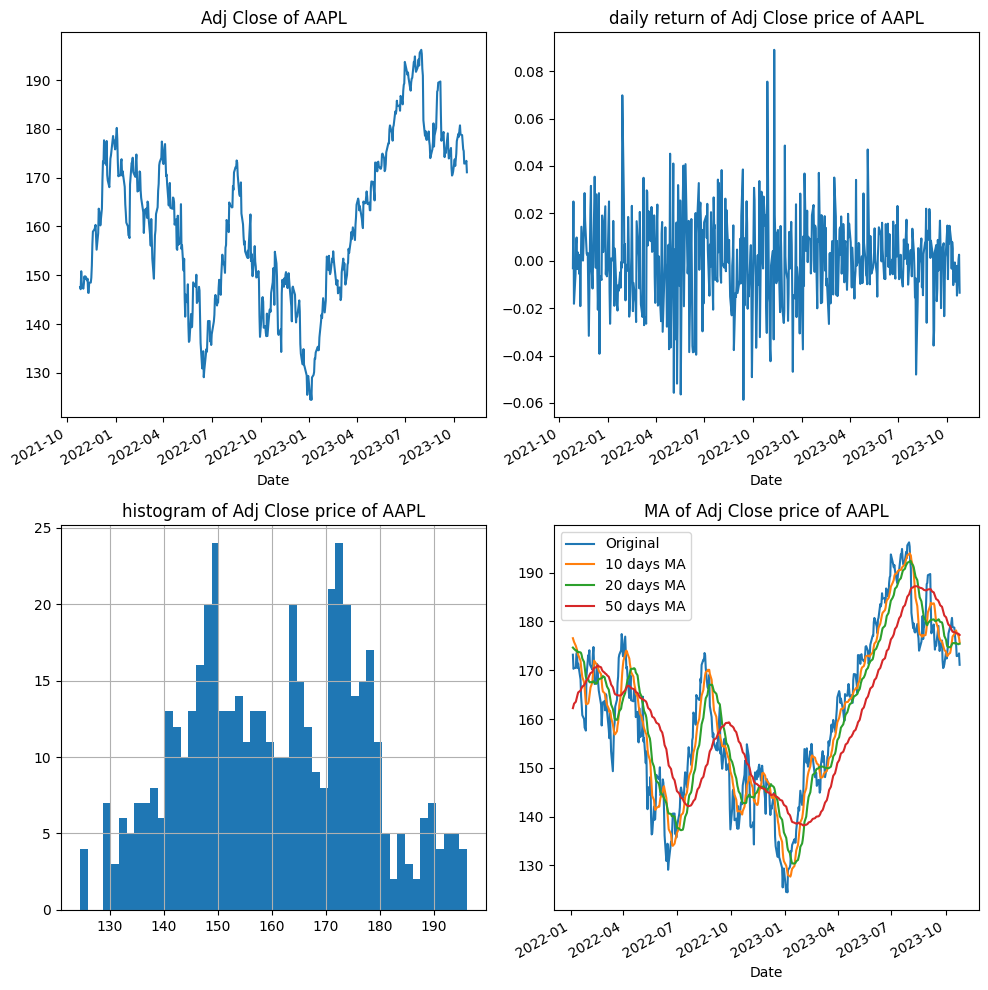

In [5]:
plot_signal(stock_name= 'AAPL', feature="Adj Close", stocks=portfolio, ma=[10,20,50])

LSTM prediction

In [6]:
def dataset_generator(stock_name=None, feature=None, duration=1, lag=60):
    end = datetime.now()
    start = datetime(end.year-duration, end.month, end.day)
    stock = get_stock_price(stock_name, start, end)[feature].values
    X = []
    y = []
    L = 60
    for i in range(lag, len(stock)- lag):
        X.append(stock[i-60:i])
        y.append(stock[i])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(np.array(X_train))
    X_test_scaled = scaler.transform(np.array(X_test))
    return X_train_scaled, X_test_scaled, np.array(y_train), np.array(y_test), scaler

In [7]:
X_train, X_test, y_train, y_test, scaler = dataset_generator(stock_name="GOOG", feature="Close", duration=10, lag=60)

[*********************100%%**********************]  1 of 1 completed


In [8]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=1, epochs=5)
model.save('LSTM_model.keras')

Epoch 1/5
1916/1916 [==============================] - 26s 12ms/step - loss: 1353.3531
Epoch 2/5
1916/1916 [==============================] - 23s 12ms/step - loss: 1259.5807
Epoch 3/5
1916/1916 [==============================] - 23s 12ms/step - loss: 709.5670
Epoch 4/5
1916/1916 [==============================] - 24s 12ms/step - loss: 9.8954
Epoch 5/5
1916/1916 [==============================] - 23s 12ms/step - loss: 8.2397


15/15 [==============================] - 0s 16ms/step


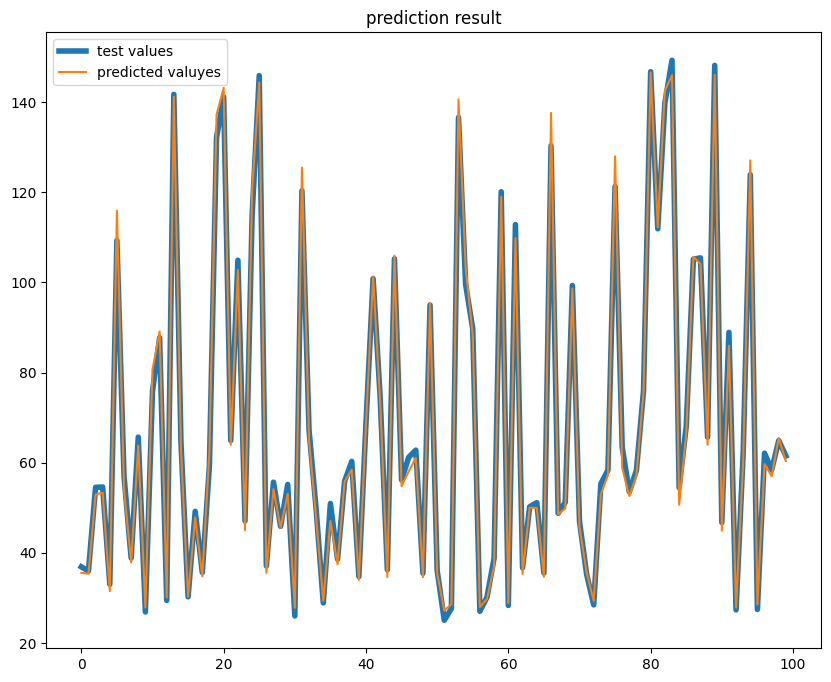

mean squarred error for test set: 6.58


In [28]:

def test_pred(X_test, y_test, scaler):
    y_pre = model.predict(X_test)
    plt.figure(figsize=(10,8))
    plt.plot(y_test[-100:], label="test values", linewidth=4)
    plt.plot(y_pre[-100:], label="predicted valuyes")
    plt.legend(loc="best")
    plt.title("prediction result")
    plt.show()
    MSE = mean_squared_error(y_test, y_pre)
    return y_pre, MSE
    
y_pre ,MSE = test_pred(X_test, y_test, scaler)
print(f"mean squarred error for test set: {np.round(MSE,2)}")